## TUIA - Aprendizaje Automático 1

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian



El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [1]:
!pip install pandas scikit-learn seaborn imblearn


In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression, ElasticNetCV, RidgeCV
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import shap
import warnings
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")

### Función que vamos a utilizar más adelante para las métricas de regresión

In [123]:
def show_metrics_regresion(y, y_pred, title, nr_neuronal=True):
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    print(title)
    print("Mean Squared Error :", mse)
    print("R-squared:", r2)
    print("Mean Absolute Error (MAE):", mae)
    if nr_neuronal:
        mape = np.mean(np.abs((y - y_pred) / y)) * 100
        print("Mean Absolute Percentage Error (MAPE):", mape)

### Función para metricas adicionales de clasificación 

In [ ]:
def show_metrics_extras(y, y_pred, title=''):
    balanced_accuracy = balanced_accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y, y_pred)
    kappa = cohen_kappa_score(y, y_pred)
    print(title)
    print(f'Especificidad: {specificity}')
    print("Precisión Balanceada:", balanced_accuracy)
    print("Coeficiente de Correlación de Matthews:", mcc)
    print("Kappa: ",kappa)

### Especificidad:

La especificidad, también conocida como tasa de verdaderos negativos (TNR), mide la proporción de casos negativos reales que se identifican correctamente como negativos. Se calcula como el número de verdaderos negativos (TN) dividido por el número total de negativos (TN + FP).

En otras palabras, la especificidad indica qué tan bien el modelo evita clasificar erróneamente las instancias negativas como positivas. Un valor de especificidad alto (cercano a 1) significa que el modelo es muy bueno para distinguir entre verdaderos negativos y falsos positivos.

### Precisión Balanceada:

La precisión balanceada, también conocida como precisión equilibrada, es una métrica diseñada específicamente para evaluar modelos de clasificación en conjuntos de datos desequilibrados. Tiene en cuenta el desequilibrio entre las clases positivas y negativas, proporcionando una evaluación más equilibrada del rendimiento del modelo.

La precisión balanceada se calcula como el promedio de la sensibilidad y la especificidad, dando el mismo peso a ambas medidas. Esto es importante en conjuntos de datos desequilibrados donde centrarse únicamente en la precisión puede ser engañoso, ya que se puede lograr una alta precisión simplemente prediciendo la clase mayoritaria (incluso si eso significa clasificar incorrectamente muchas instancias de la clase minoritaria).

### Coeficiente de Correlación de Matthews (MCC):

El coeficiente de correlación de Matthews (MCC), también conocido como coeficiente de correlación de Matthews, es una métrica completa que considera tanto los verdaderos positivos como los verdaderos negativos, proporcionando una evaluación más robusta del rendimiento de la clasificación. Se calcula como el coeficiente de correlación entre las etiquetas de clase binarias predichas y reales.

MCC varía de -1 a 1, donde 1 indica una concordancia perfecta entre las etiquetas predichas y reales, 0 indica que no hay correlación y -1 indica una discordancia completa. Un valor MCC más alto (más cercano a 1) indica un mejor rendimiento.

### Kappa:

Kappa, también conocido como kappa de Cohen, es una medida estadística de concordancia entre dos anotadores o clasificaciones. Tiene en cuenta la posibilidad de concordancia aleatoria, proporcionando una evaluación de concordancia más matizada que simplemente comparar el porcentaje de etiquetas coincidentes.

Kappa varía de 0 a 1, donde 1 indica una concordancia perfecta, 0 indica que no hay concordancia más allá del azar y los valores negativos indican una concordancia peor que el azar. Un valor kappa más alto (más cercano a 1) indica una mejor concordancia entre las etiquetas predichas y reales.

## Importamos el dataset

In [4]:
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',')

## Filtramos por las ciudades de interés, convertimos a formato date la fecha y las ordenamos de forma ascendente


In [5]:
ciudades = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']
df = df[df['Location'].isin(ciudades)]
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

## Visualizamos la distribución de los datos por año

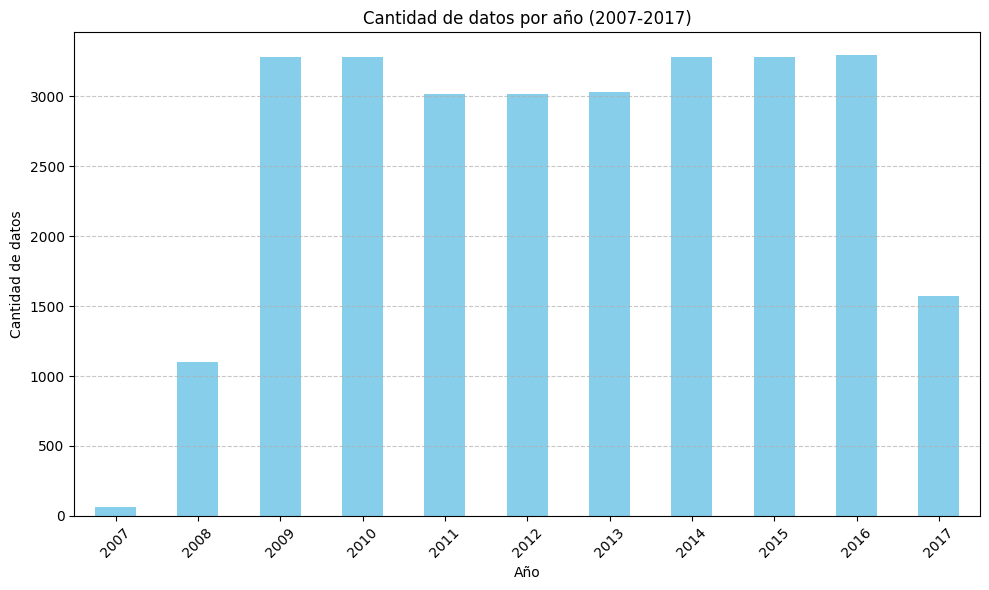

In [6]:
df['Year'] = pd.to_datetime(df['Date']).dt.year # Creamos la columna Year para poder realizar la visualización por año

# Contamos la cantidad de datos por año
data_by_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
data_by_year.plot(kind='bar', color='skyblue')
plt.title('Cantidad de datos por año (2007-2017)')
plt.xlabel('Año')
plt.ylabel('Cantidad de datos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
df = df.drop(columns=['Year']) # Eliminamos la columna Year

## Realizamos el split de entrenamiento y prueba 

Decidimos dividir el conjunto de datos de forma manual. Esta elección se debe a que posteriormente imputaremos los valores basados en la fecha. Si utilizáramos la función train_test_split, la separación sería aleatoria, lo que podría provocar una fuga de datos.


In [7]:
# Definimos las fechas límite para la división
date_train_limit = pd.to_datetime('2015-10-06')

# Filtramos el DataFrame para obtener los conjuntos de entrenamiento y prueba
train = df[df['Date'] <= date_train_limit]
test = df[df['Date'] > date_train_limit]

print(f"El conjunto de entrenamiento tiene {len(train)} registros y va hasta la fecha {date_train_limit}.")
print(f"El conjunto de prueba tiene {len(test)} registros y empieza a partir de la fecha {date_train_limit}.")

El conjunto de entrenamiento tiene 22590 registros y va hasta la fecha 2015-10-06 00:00:00.
El conjunto de prueba tiene 5643 registros y empieza a partir de la fecha 2015-10-06 00:00:00.


## Análisis descriptivo

Se realizará un análisis exploratorio del conjunto de datos de entrenamiento para entender sus características principales y determinar si se requiere alguna acción para abordar datos faltantes, valores atípicos, la codificación de variables categóricas u otros procesos antes de proceder.

In [8]:
train.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [9]:
train.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
45573,45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,...,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes,3.6
45574,45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,...,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,3.6
45575,45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,...,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,39.8
45576,45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,...,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,2.8
45577,45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,...,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No,0.0


In [10]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 22590 entries, 45573 to 83352
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        22590 non-null  int64         
 1   Date              22590 non-null  datetime64[ns]
 2   Location          22590 non-null  object        
 3   MinTemp           22233 non-null  float64       
 4   MaxTemp           22246 non-null  float64       
 5   Rainfall          21848 non-null  float64       
 6   Evaporation       20574 non-null  float64       
 7   Sunshine          18628 non-null  float64       
 8   WindGustDir       21019 non-null  object        
 9   WindGustSpeed     21022 non-null  float64       
 10  WindDir9am        21175 non-null  object        
 11  WindDir3pm        22176 non-null  object        
 12  WindSpeed9am      22240 non-null  float64       
 13  WindSpeed3pm      22254 non-null  float64       
 14  Humidity9am       21985

Unnamed: 0             0
Date                   0
Location               0
MinTemp              357
MaxTemp              344
Rainfall             742
Evaporation         2016
Sunshine            3962
WindGustDir         1571
WindGustSpeed       1568
WindDir9am          1415
WindDir3pm           414
WindSpeed9am         350
WindSpeed3pm         336
Humidity9am          605
Humidity3pm          561
Pressure9am          625
Pressure3pm          618
Cloud9am            7179
Cloud3pm            7469
Temp9am              372
Temp3pm              366
RainToday            742
RainTomorrow         742
RainfallTomorrow     742
dtype: int64

### **Hay un total de 22590 datos de entrenamiento, 25 columnas y se puede observar que hay datos nulos en la mayoria de las variables.**

### Eliminamos la columna 'Unnamed: 0' y 'Location'
Eliminamos la columna Location ya que vamos a considerarlas a todas como una sola

In [11]:
train = train.drop(columns=['Unnamed: 0', 'Location'])

### Cambiamos los valores nulos
Debido a que tomamos las ciudades como una única localidad, decidimos reemplazar los valores faltantes por otro de la misma fecha o, en su defecto, por la más cercana.

In [12]:
train.sort_values(by='Date', inplace=True)
train.fillna(method='ffill', inplace=True)

In [13]:
train.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

### Eliminamos la columna Date:
La razon es que ya no la vamos a usar, solo la usamos como criterio para el reemplazo de los valores nulos

In [14]:
train = train.drop(columns=['Date'])

In [15]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

## Creación de columnas 
Con el objetivo de reducir la cantidad de columnas y mejorar la explicabilidad del modelo, decidimos agrupar las variables que representan dos momentos del día en una sola columna.

In [16]:
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
train['PressureVariation'] = train['Pressure3pm'] - train['Pressure9am']
train['TempVariation'] = train['Temp3pm'] - train['Temp9am']
train['HumidityVariation'] = train['Humidity3pm'] - train['Humidity9am']
train['CloudVariation'] = train['Cloud3pm'] - train['Cloud9am']
train['WindSpeedVariation'] = train['WindSpeed3pm'] - train['WindSpeed9am']
train.drop(columns=columns_to_aggregate, inplace=True)


In [17]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow', 'RainfallTomorrow', 'PressureVariation',
       'TempVariation', 'HumidityVariation', 'CloudVariation',
       'WindSpeedVariation'],
      dtype='object')

### Estadística descriptiva de las variables numéricas
Examinamos medidas estadísticas, incluyendo valores mínimos, máximos, cuartiles, y medidas de centralidad como la mediana (50%) y la media.

In [18]:
train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,RainfallTomorrow,PressureVariation,TempVariation,HumidityVariation,CloudVariation,WindSpeedVariation
count,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000
mean,11.061669,21.624812,2.031921,4.676733,6.858752,42.163612,2.024914,-2.102975,4.910801,-18.345418,0.128862,4.876184
std,5.693569,6.603190,6.398745,3.595545,3.853037,14.317466,6.337360,2.111616,3.420125,15.748060,2.610961,9.062311
min,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,-13.800000,-10.200000,-89.000000,-8.000000,-46.000000
25%,7.300000,16.400000,0.000000,2.200000,3.800000,31.000000,0.000000,-3.500000,2.600000,-28.000000,-1.000000,0.000000
50%,10.700000,20.700000,0.000000,4.000000,7.300000,41.000000,0.000000,-2.300000,4.600000,-18.000000,0.000000,5.000000
75%,14.900000,25.800000,1.000000,6.400000,10.000000,50.000000,1.000000,-0.900000,7.100000,-9.000000,1.000000,11.000000
max,33.900000,46.800000,119.400000,64.800000,14.300000,122.000000,119.400000,20.400000,23.000000,76.000000,8.000000,52.000000


Al analizar las columnas, se percibe que tanto la media como la mediana muestran una cercanía notable, lo que sugiere una tendencia consistente en los datos. Los desvíos en la dispersión de los datos no son extremos y la distribución no presentaria una gran extensión en un boxplot.

Los valores mínimos y máximos registrados estan considerablemente alejados de los valores centrales, lo cual señala la posible existencia de valores atípicos dentro del conjunto de datos.

## **Bloxplot**

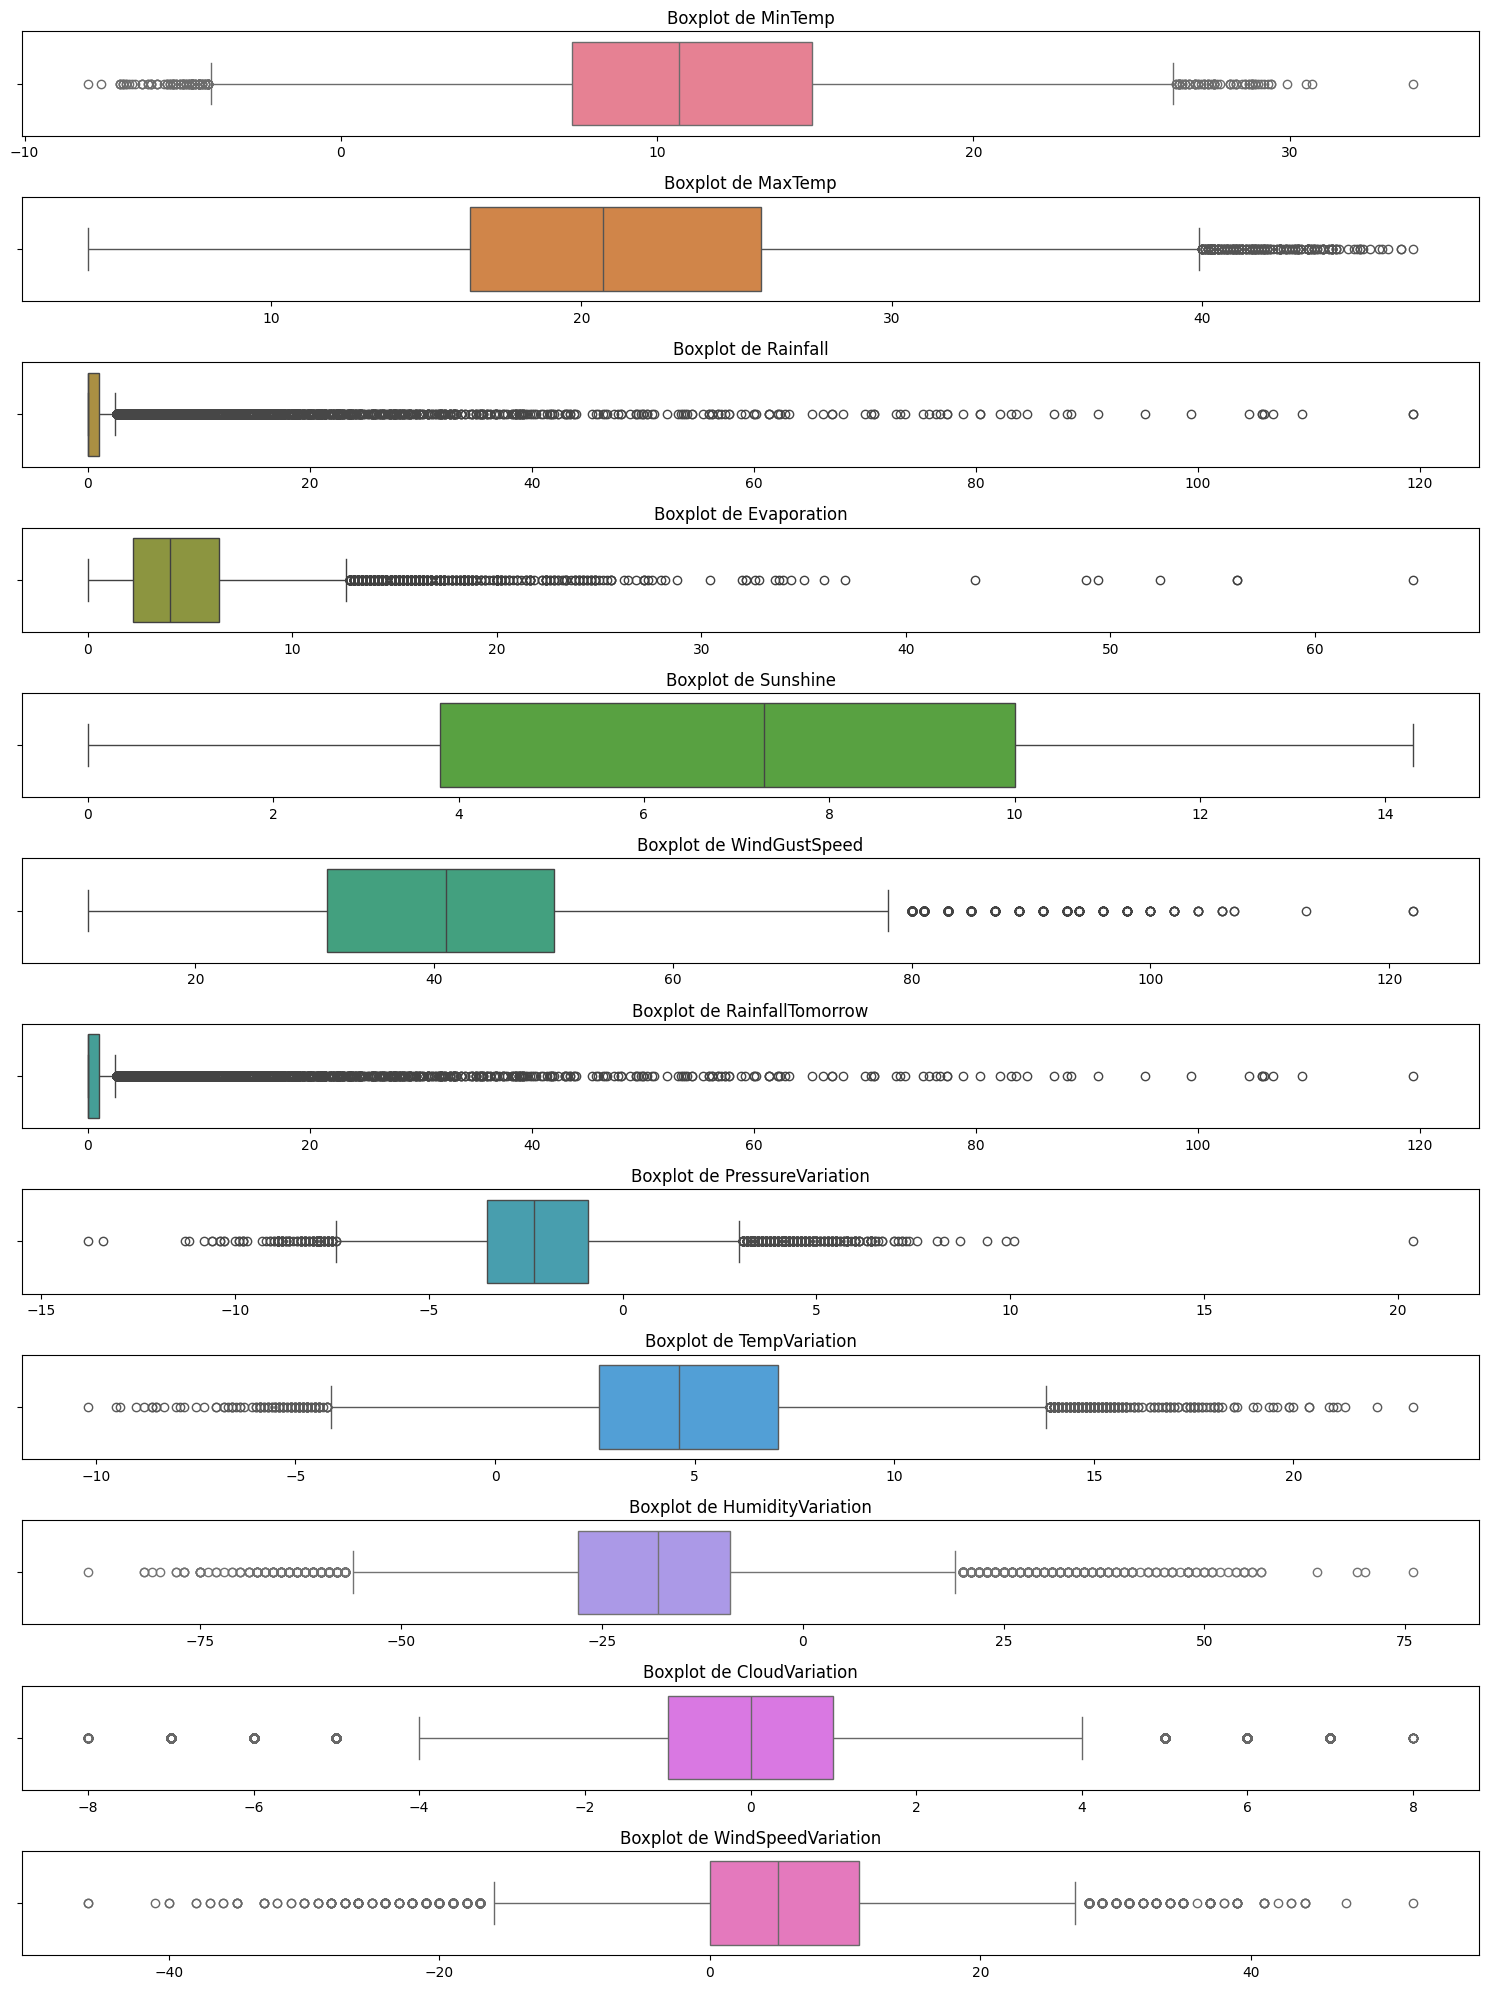

In [19]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

colores = sns.color_palette('husl', n_colors=len(numeric_columns))

fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(15, 20), sharex=False)

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=train, x=col, ax=axes[i], color=colores[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('')

plt.tight_layout()

plt.show()

### Se puede observar una gran presencia de valores atípicos en la mayoría de las variables

## Histograma

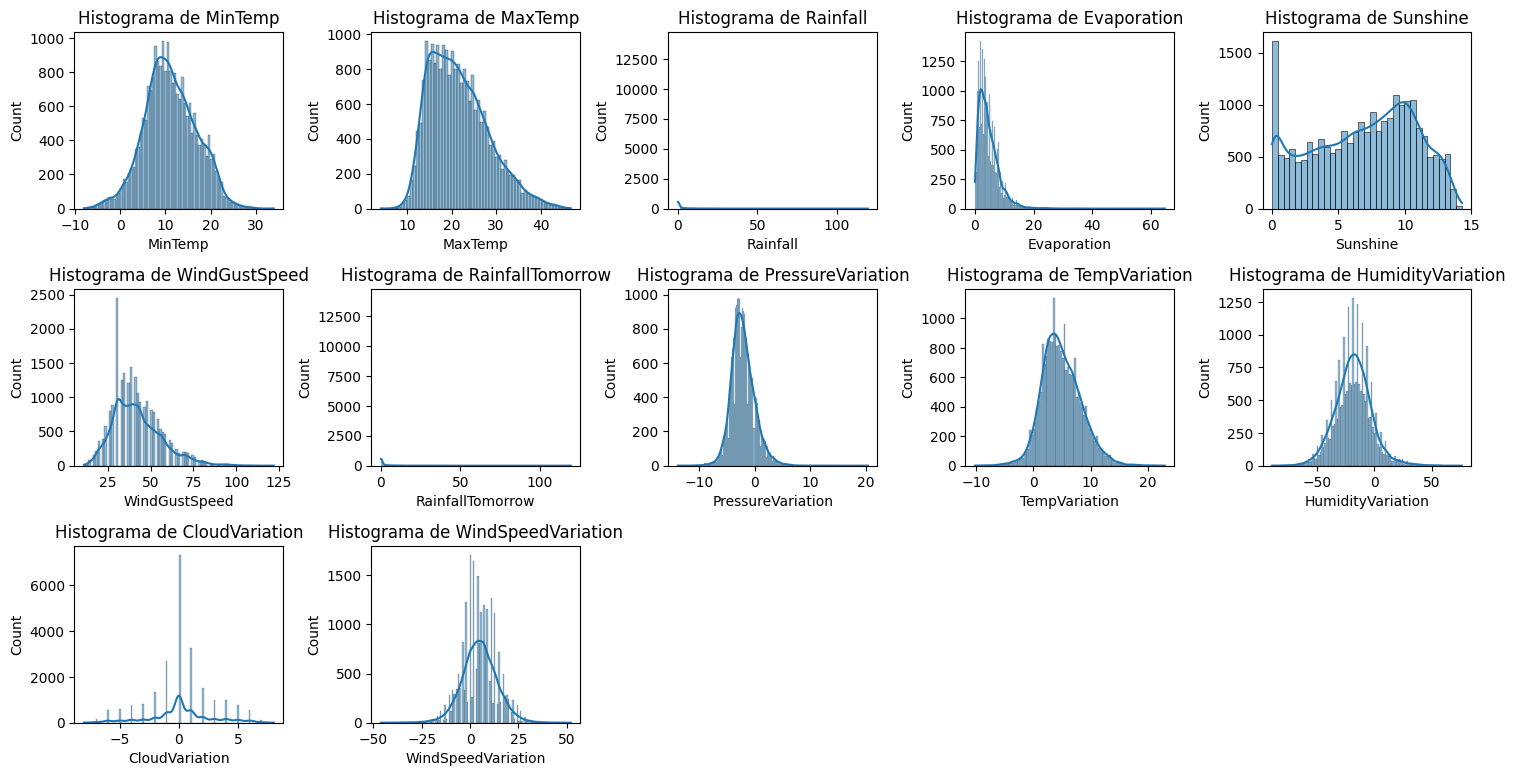

In [20]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(train[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()

Para comprender más a fondo el comportamiento de los datos, empleamos histogramas donde se puede apreciar que algunas variables exhiben una distribución más uniforme de sus valores, como es el caso de la temperatura, humedad y presión. Por otro lado, existen variables que muestran la presencia de múltiples modas en los datos y una distribución menos uniforme.

Asimismo, se destaca que la variable Rainfall concentra la gran mayoría de sus datos en cero.

## Analizamos nuestra variable objetivo, la que queremos predecir para saber si el dataset esta balanceado o no.
Primero convertimos las variables categóricas en numéricas

In [21]:
train['RainToday'] = train['RainToday'].map({'No': 0, 'Yes': 1})
train['RainTomorrow'] = train['RainTomorrow'].map({'No': 0, 'Yes': 1})

test['RainToday'] = test['RainToday'].map({'No': 0, 'Yes': 1})
test['RainTomorrow'] = test['RainTomorrow'].map({'No': 0, 'Yes': 1})

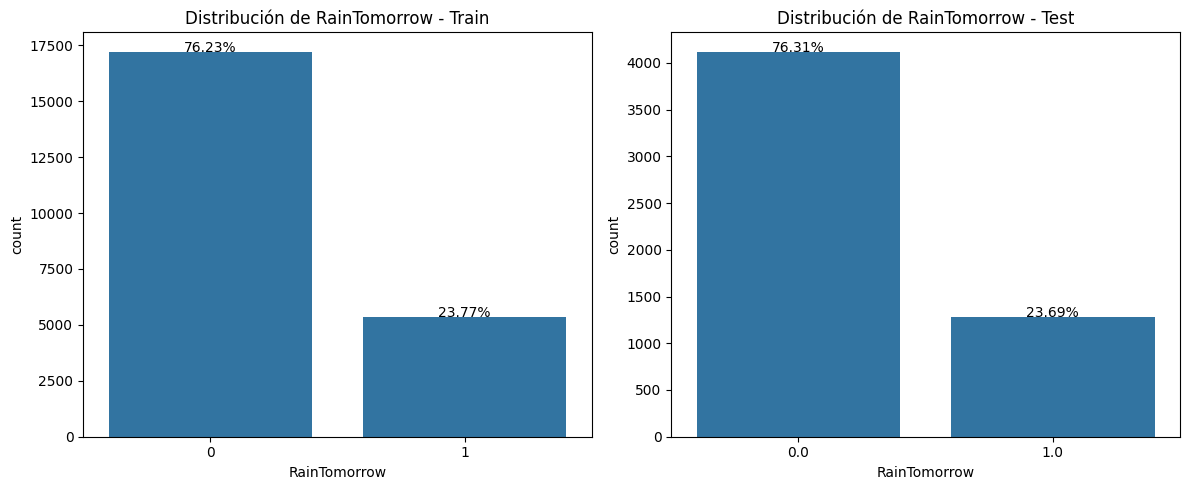

In [22]:
# Calculamos los porcentajes para el conjunto de entrenamiento
train_percentages = train['RainTomorrow'].value_counts(normalize=True) * 100
# Calculamos los porcentajes para el conjunto de prueba
test_percentages = test['RainTomorrow'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='RainTomorrow', data=train)
plt.title('Distribución de RainTomorrow - Train')
for i, value in enumerate(train_percentages):
    plt.text(i, train['RainTomorrow'].value_counts()[i], f'{value:.2f}%', ha='center')

plt.subplot(1, 2, 2)
sns.countplot(x='RainTomorrow', data=test)
plt.title('Distribución de RainTomorrow - Test')
for i, value in enumerate(test_percentages):
    plt.text(i, test['RainTomorrow'].value_counts()[i], f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()


### Se observa que tanto en el conjuntos de entrenamiento como en el de prueba hay una mayor cantidad de datos donde no llueve (0) comparado con los días que llueve (1). Esto puede hacer que el modelo tenga un sesgo muy importante al momento de predecir. Por esta razón, podemos decir que los datos no se encuentran balanceados.
### Podemos ver una relacion 3 a 1 aproximadamente, en este caso existe la posibilidad de balancear el dataset.

# Matriz de correlación 

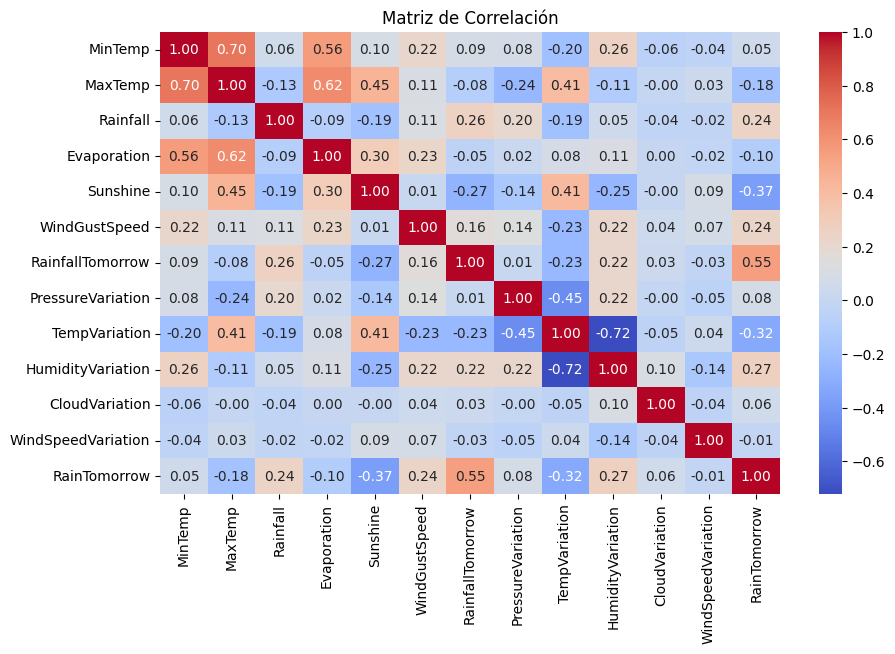

In [23]:
numeric_columns = numeric_columns.append(pd.Index(['RainTomorrow']))
correlation_matrix_numeric = train[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Podemos observar que las variables con mayor correlación positiva con RainfallTomorrow son:

*   Rainfall (0.25)
*   HumidityVariation (0.22)
*   WindGustSpeed (0.17)

Las variables con mayor correlación negativa con RainfallTomorrow son:
*   Sunshine (-0.28)
*   TempVariation (-0.23)

Las variables con mayor correlación positiva con RainTomorrow son:

*   RainfallTomorrow (0.55)
*   HumidityVariation (0,27)
*   Rainfall (0.24)
*   WindGustSpeed (0,24)

Las variables con mayor correlación negativa con RainTomorrow son:
*   Sunshine (-0.37)
*   TempVariation (-0.32)

## Para poder ver las metricas de test necesitamos aplicarle los mismos cambios que se hicieron en train.

In [24]:
test.sort_values(by='Date', inplace=True)

for column in test.columns:
    test[column] = test[column].ffill()
    test[column] = test[column].bfill() 
    
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
test = test.drop(columns=['Unnamed: 0', 'Location','Date'])
test['PressureVariation'] = test['Pressure3pm'] - test['Pressure9am']
test['TempVariation'] = test['Temp3pm'] - test['Temp9am']
test['HumidityVariation'] = test['Humidity3pm'] - test['Humidity9am']
test['CloudVariation'] = test['Cloud3pm'] - test['Cloud9am']
test['WindSpeedVariation'] = test['WindSpeed3pm'] - test['WindSpeed9am']
test.drop(columns=columns_to_aggregate, inplace=True)


# Método LinearRegression

Evaluamos el modelo con los datos de entrenamiento y luego con los de test

In [25]:
X_train = train.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_train = train['RainfallTomorrow']
X_test = test.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_test = test['RainfallTomorrow']
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")

Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.194637493217684
R-squared: 0.17344762532096447
Mean Absolute Error (MAE): 2.716306730234828
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.129708978452435
R-squared: 0.19087344363865177
Mean Absolute Error (MAE): 2.8544855627909227
Mean Absolute Percentage Error (MAPE): inf


### No se observa presencia de overfiting, podemos notar que las metricas de train y test son bastante similares

## Crear un explainer SHAP


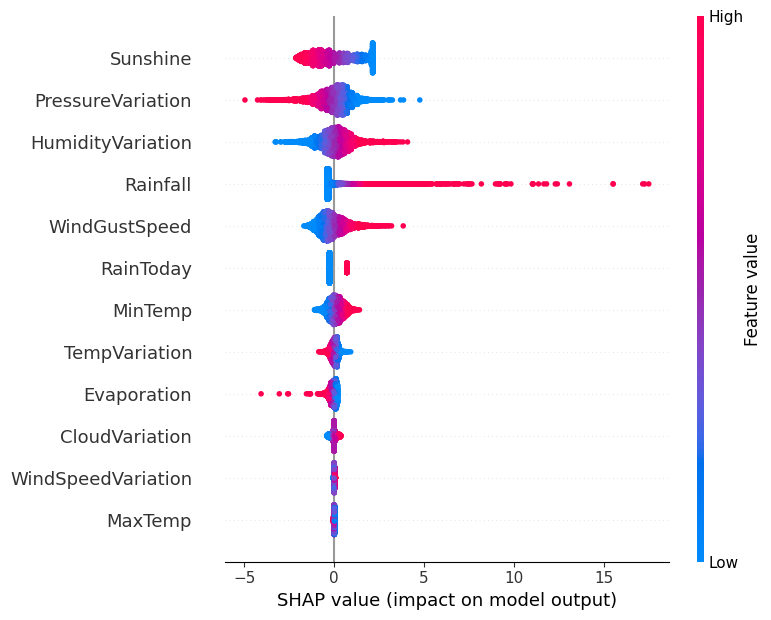

ValueError: Could not find feature named: FeatureName

In [26]:
explainer = shap.Explainer(model, X_train)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Gráfica de Resumen Global
shap.summary_plot(shap_values, X_test)

# Gráfico de Dependencia Local (para la primera característica)
shap.dependence_plot("FeatureName", shap_values, X_test)

# Gráfico de Dependencia Local (para la segunda característica)
shap.dependence_plot("FeatureName", shap_values, X_test)

plt.show()

El gráfico de valores SHAP revela la importancia y el impacto de cada característica en las predicciones del modelo. 

Características con valores SHAP más altos, como rainfall, tienen una influencia más fuerte en las predicciones, mientras que aquellos cerca de cero tienen un efecto mínimo, como maxtemp.

Cada punto representa un valor SHAP de una característica para una observación específica. 

La dispersión de los puntos a lo largo del eje X indica la magnitud y la dirección del impacto de la característica en la predicción. 

Características más importantes están ubicadas más arriba en el gráfico, como por ejemplo sunshine y pressurevariation.

# Método de gradiente descendiente

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    n, m = X_train.shape
    o, _ = X_test.shape

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    # Convertir y_train de Series a un array de numpy
    y_train = y_train.values

    # Inicializar pesos aleatorios
    W = np.random.randn(m + 1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = X_train @ W
        error_train = y_train.reshape(-1, 1) - prediction_train  
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = X_test @ W
        error_test = y_test.values.reshape(-1, 1) - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        gradient = -2/n * X_train.T @ error_train
        W -= lr * gradient

    # Graficar errores de entrenamiento y prueba
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de test')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    plt.show()

    return W


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=200)

'''
sgd_model = SGDRegressor(loss='squared_error', max_iter=3000, random_state=42)
sgd_model.fit(X_train, y_train)
y_pred_train = sgd_model.predict(X_train)
y_pred_test = sgd_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")'''

Notamos en este método, que las métricas de r2 comparadas con la regresión lineal son peores.

# Métodos de regularización Lasso

In [ ]:
# Crear y entrenar el modelo Lasso
lasso_model = Lasso(alpha=0.1)  # alpha es el parámetro de regularización
lasso_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")


## Lasso con validación cruzada

In [ ]:

lasso_cv_model = LassoCV(cv=5)
lasso_cv_model.fit(X_train, y_train)
y_pred_train_cv = lasso_cv_model.predict(X_train)
y_pred_test_cv = lasso_cv_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_cv, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_cv, "Métricas sobre los datos de prueba:")


## Lasso con random_search

In [ ]:
# Define los rangos de valores para los hiperparámetros que quieres explorar
param_distributions = {
    'alpha': uniform(0.1, 100.0),  # Rango uniforme entre 0.1 y 100.0 para alpha
}
# Crea una instancia del modelo Lasso
lasso_model = Lasso()
# Crea una instancia de RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lasso_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=10,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)

# Entrena el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print(f"Mejores hiperparámetros encontrados:{random_search.best_params_}" )
# Hacer predicciones con el mejor modelo encontrado
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)

show_metrics_regresion(y_train, y_pred_train_rs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_rs, "Métricas sobre los datos de prueba:")


## Lasso con grid_search

In [ ]:
# Define los valores de los hiperparámetros que quieres explorar
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]  # Lista de valores para alpha
}
lasso_model = Lasso()
grid_search = GridSearchCV(estimator=lasso_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada

grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros encontrados:{}".format(grid_search.best_params_))
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_gs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_gs, "Métricas sobre los datos de prueba:")


# Regresión de Ridge

In [ ]:
ridge_model = Ridge(alpha=0.1)  # alpha es el parámetro de regularización
ridge_model.fit(X_train, y_train)
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")


Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.194637493390175
R-squared: 0.17344762531666946
Mean Absolute Error (MAE): 2.7163058016230766
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.12970805721611
R-squared: 0.19087346426978336
Mean Absolute Error (MAE): 2.854484774754714
Mean Absolute Percentage Error (MAPE): inf


## Ridge con validación cruzada

In [ ]:
alphas = [0.001, 0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]  # Puedes ajustar esta lista según sea necesario
ridge_cv_model = RidgeCV(alphas=alphas)
ridge_cv_model.fit(X_train, y_train)
y_pred_train_cv = ridge_cv_model.predict(X_train)
y_pred_test_cv = ridge_cv_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_cv, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_cv, "Métricas sobre los datos de prueba:")

Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.19463920422421
R-squared: 0.17344758271659777
Mean Absolute Error (MAE): 2.7162144718460044
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.129619202678576
R-squared: 0.19087545417139073
Mean Absolute Error (MAE): 2.8544074642878337
Mean Absolute Percentage Error (MAPE): inf


## Ridge con random_search

In [ ]:

param_distributions = {
    'alpha': uniform(0.1, 100.0),  # Rango uniforme entre 0.1 y 100.0 para alpha
}
ridge_model = Ridge()
random_search = RandomizedSearchCV(estimator=ridge_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=10,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)
random_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{random_search.best_params_}")
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_rs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_rs, "Métricas sobre los datos de prueba:")

## Ridge con grid_search

In [ ]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]  # Lista de valores para alpha
}
ridge_model = Ridge()
grid_search = GridSearchCV(estimator=ridge_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada
grid_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{grid_search.best_params_}")
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_gs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_gs, "Métricas sobre los datos de prueba:")


## Método de regularización Elasticnet

In [ ]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha es el parámetro de regularización, l1_ratio controla la proporción de L1 y L2
elastic_net_model.fit(X_train, y_train)
y_pred_train = elastic_net_model.predict(X_train)
y_pred_test = elastic_net_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")

## Elasticnet con validación cruzada

In [ ]:
alphas = [0.001, 0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]
elastic_net_cv_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)
elastic_net_cv_model.fit(X_train, y_train)
y_pred_train_cv = elastic_net_cv_model.predict(X_train)
y_pred_test_cv = elastic_net_cv_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_cv, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_cv, "Métricas sobre los datos de prueba:")


## Elasticnet con random_search

In [ ]:
param_distributions = {
    'alpha': uniform(0.01, 10.0),  # Rango uniforme entre 0.1 y 10.0 para alpha
    'l1_ratio': uniform(0, 1),     # Rango uniforme entre 0 y 1 para l1_ratio
}
elastic_net_model = ElasticNet()
random_search = RandomizedSearchCV(estimator=elastic_net_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=100,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)

random_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{random_search.best_params_}")
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_rs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_rs, "Métricas sobre los datos de prueba:")


## Elasticnet con grid_search

In [ ]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0],  # Lista de valores para alpha
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Lista de valores para l1_ratio
}
elastic_net_model = ElasticNet()
grid_search = GridSearchCV(estimator=elastic_net_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada
grid_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{grid_search.best_params_}")
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_gs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_gs, "Métricas sobre los datos de prueba:")

### Con respecto a las métricas, elegimos el r2 para comparar los distintos modelos
### Necesitamos comparar los resultados obtenidos tanto en entrenamiento como en prueba para poder determinar si nuestro modelo esta ajustando correctamente.


# Regresión Logística

### Definimos las variables para clasificación

In [ ]:
y_train_clasification =train['RainTomorrow']
y_test_clasification = test['RainTomorrow']

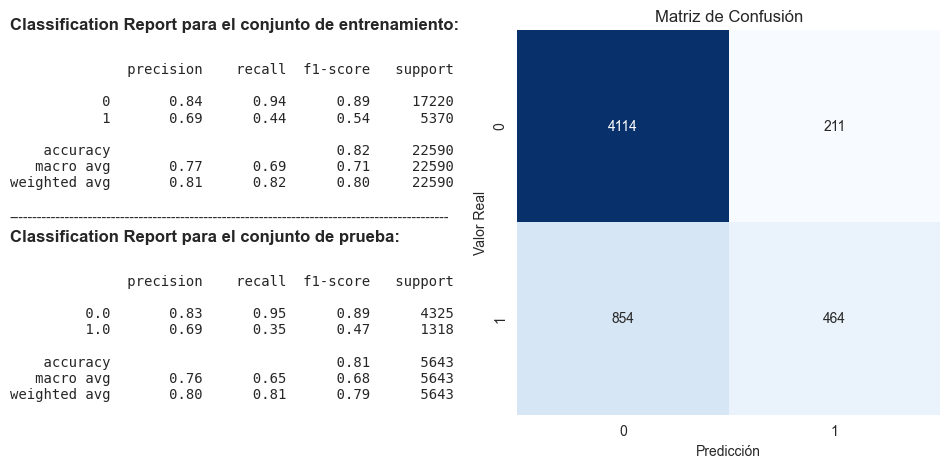

<Figure size 400x300 with 0 Axes>

In [ ]:
logistic_model1 = LogisticRegression(random_state=42)
logistic_model1.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model1.predict(X_train)
y_pred_test = logistic_model1.predict(X_test)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

### Crear un explainer SHAP para el modelo de clasificacion

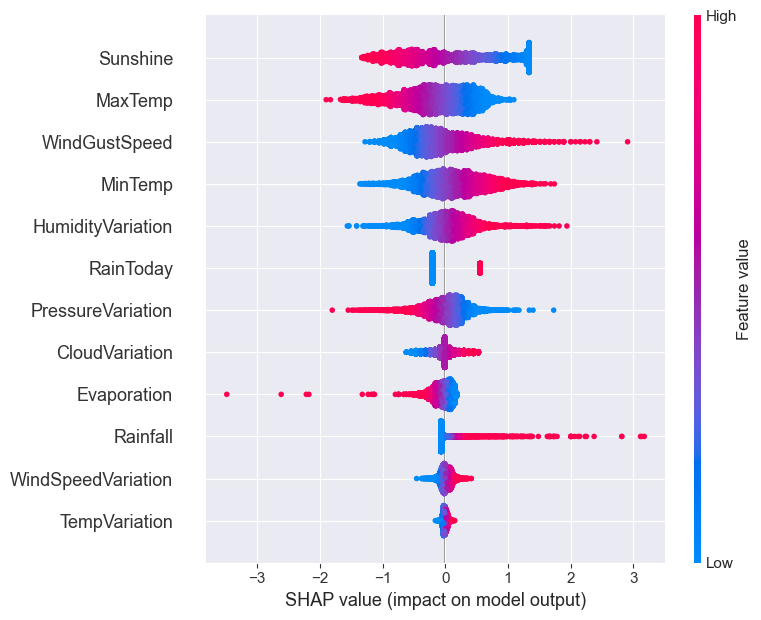

ValueError: Could not find feature named: FeatureName

In [ ]:
explainer = shap.Explainer(logistic_model1, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
shap.dependence_plot("FeatureName", shap_values, X_test)
shap.dependence_plot("FeatureName", shap_values, X_test)
plt.show()

## Regresión logística con penalización por clases

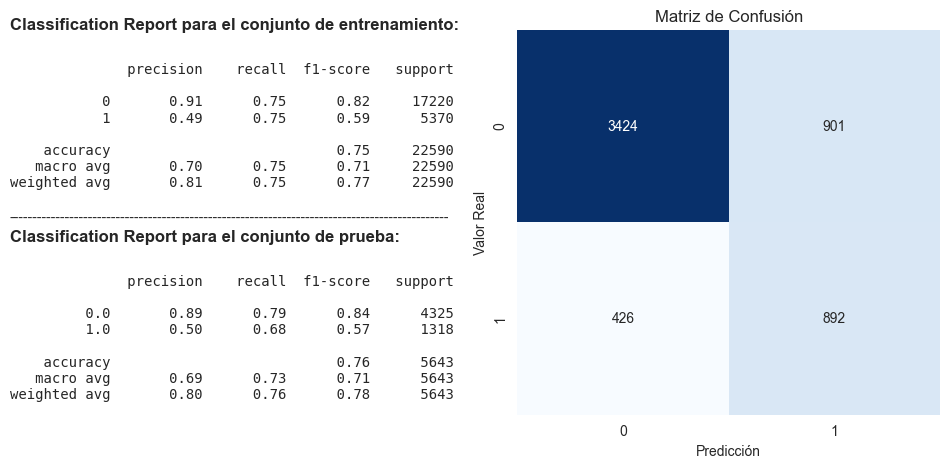

<Figure size 400x300 with 0 Axes>

In [ ]:
logistic_model2 = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model2.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model2.predict(X_train)
y_pred_test = logistic_model2.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## Regresión logística con balanceo de clases SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_clasification)

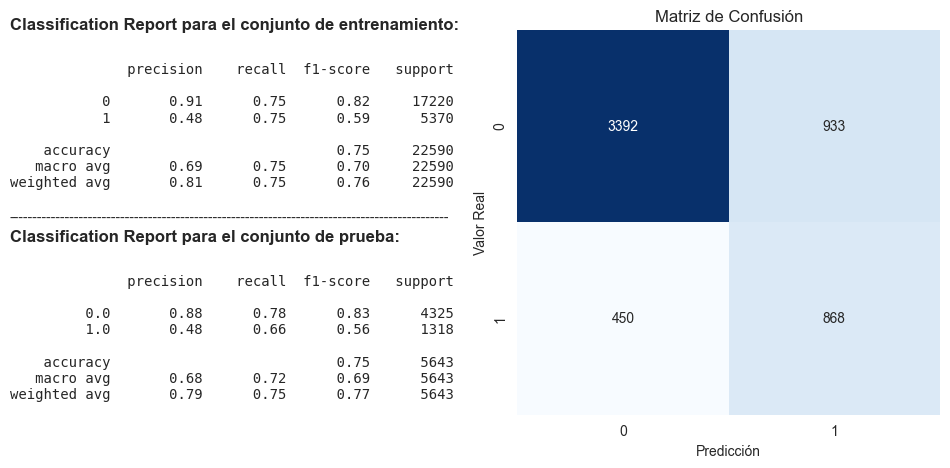

<Figure size 400x300 with 0 Axes>

In [ ]:
logistic_model3 = LogisticRegression(random_state=42)
logistic_model3.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred_train = logistic_model3.predict(X_train)
y_pred_test = logistic_model3.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

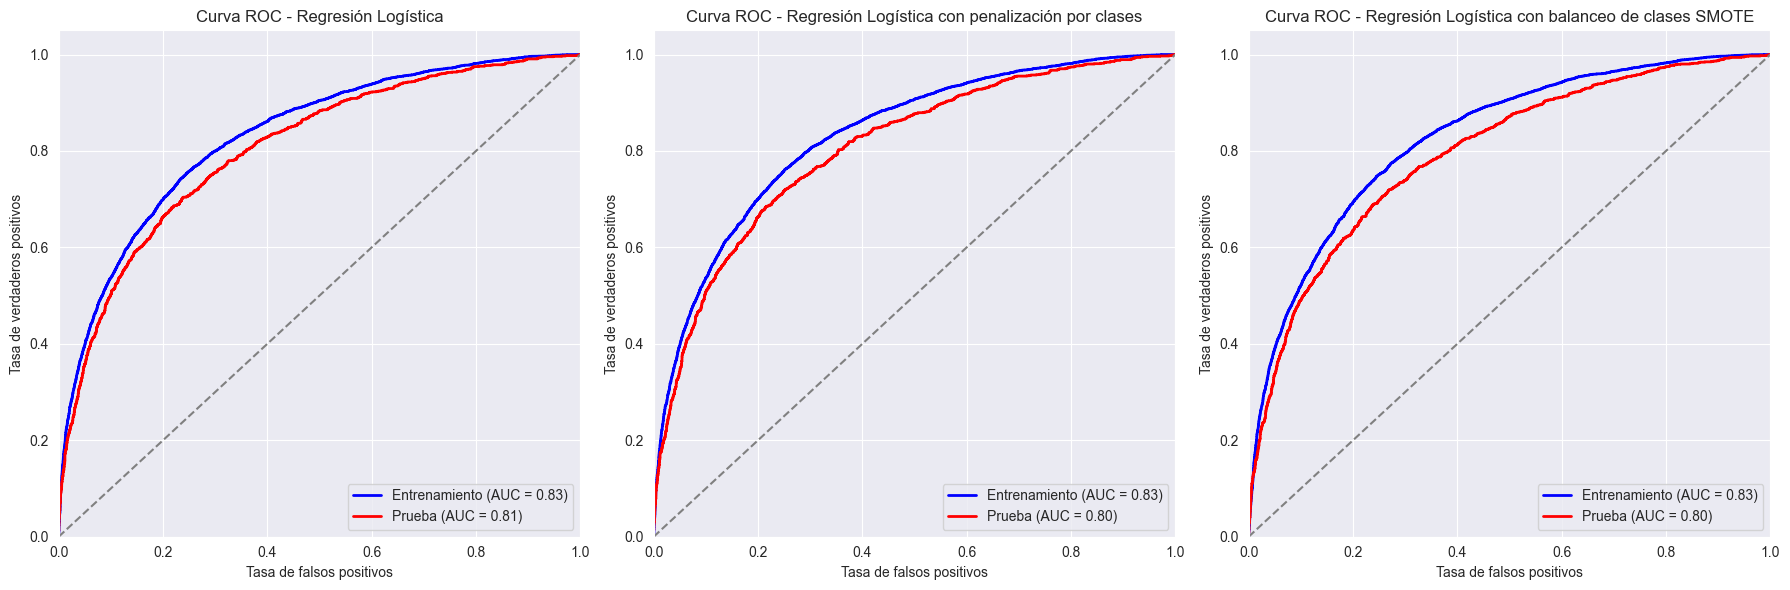

In [ ]:
# Obtener las probabilidades de predicción de la clase positiva para entrenamiento y prueba para cada modelo
y_pred_proba_train1 = logistic_model1.predict_proba(X_train)[:, 1]
y_pred_proba_test1 = logistic_model1.predict_proba(X_test)[:, 1]

y_pred_proba_train2 = logistic_model2.predict_proba(X_train)[:, 1]
y_pred_proba_test2 = logistic_model2.predict_proba(X_test)[:, 1]

y_pred_proba_train3 = logistic_model3.predict_proba(X_train)[:, 1]
y_pred_proba_test3 = logistic_model3.predict_proba(X_test)[:, 1]

# Calcular la curva ROC para entrenamiento y prueba para cada modelo
fpr_train1, tpr_train1, _ = roc_curve(y_train_clasification, y_pred_proba_train1)
fpr_test1, tpr_test1, _ = roc_curve(y_test_clasification, y_pred_proba_test1)
auc_train1 = roc_auc_score(y_train_clasification, y_pred_proba_train1)
auc_test1 = roc_auc_score(y_test_clasification, y_pred_proba_test1)

fpr_train2, tpr_train2, _ = roc_curve(y_train_clasification, y_pred_proba_train2)
fpr_test2, tpr_test2, _ = roc_curve(y_test_clasification, y_pred_proba_test2)
auc_train2 = roc_auc_score(y_train_clasification, y_pred_proba_train2)
auc_test2 = roc_auc_score(y_test_clasification, y_pred_proba_test2)

fpr_train3, tpr_train3, _ = roc_curve(y_train_clasification, y_pred_proba_train3)
fpr_test3, tpr_test3, _ = roc_curve(y_test_clasification, y_pred_proba_test3)
auc_train3 = roc_auc_score(y_train_clasification, y_pred_proba_train3)
auc_test3 = roc_auc_score(y_test_clasification, y_pred_proba_test3)

# Trazar las curvas ROC para entrenamiento y prueba para cada modelo en una sola fila
plt.figure(figsize=(18, 6))

# Modelo 1
plt.subplot(1, 3, 1)
plt.plot(fpr_train1, tpr_train1, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train1)
plt.plot(fpr_test1, tpr_test1, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test1)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')

# Modelo 2
plt.subplot(1, 3, 2)
plt.plot(fpr_train2, tpr_train2, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train2)
plt.plot(fpr_test2, tpr_test2, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística con penalización por clases')
plt.legend(loc='lower right')

# Modelo 3
plt.subplot(1, 3, 3)
plt.plot(fpr_train3, tpr_train3, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train3)
plt.plot(fpr_test3, tpr_test3, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test3)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística con balanceo de clases SMOTE')
plt.legend(loc='lower right')

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

### Podemos notar que al aplicar el método de sobre muestreo SMOTE o la regresión logística con penalización a la clase minoritaria podemos notar una mejora en los valores de recall

## Modelo Clasificar base 

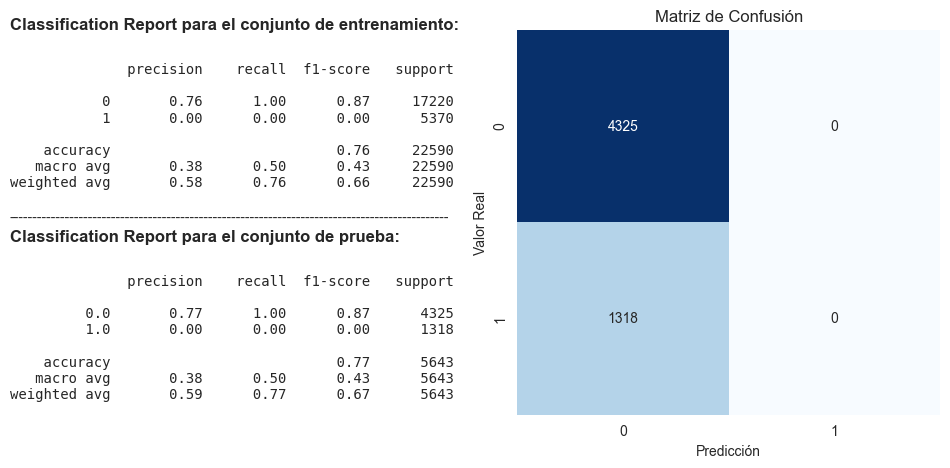

<Figure size 400x300 with 0 Axes>

In [ ]:
# Crear el clasificador ingenuo que predice la clase mayoritaria
naive_classifier = DummyClassifier(strategy="most_frequent")

# Entrenar el modelo con los datos de entrenamiento
naive_classifier.fit(X_train, y_train_clasification)

# Hacer predicciones sobre los datos de entrenamiento y prueba
y_pred_train = naive_classifier.predict(X_train)
y_pred_test = naive_classifier.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')
ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## curva ROC de modelo base

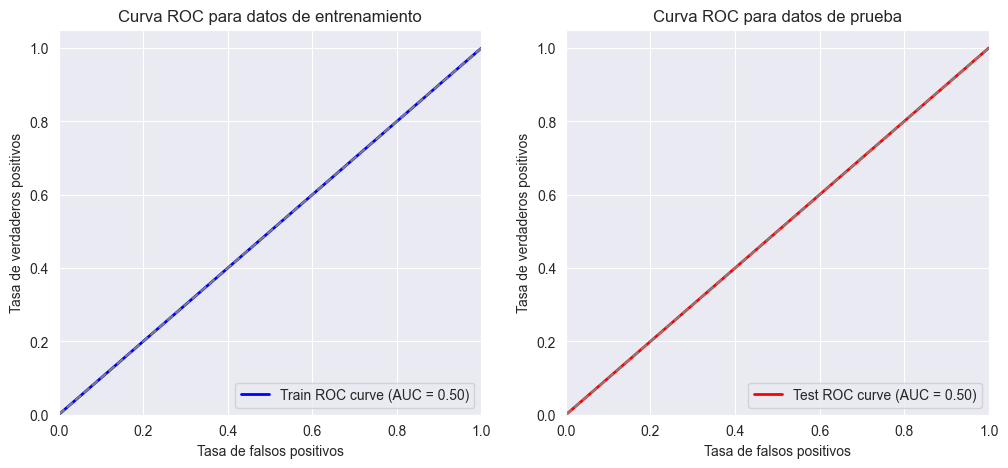

In [ ]:
# Obtener las probabilidades de predicción de la clase positiva (la clase mayoritaria)
y_pred_proba_train = np.full_like(y_train_clasification, fill_value=1)  # Clase mayoritaria
y_pred_proba_test = np.full_like(y_test_clasification, fill_value=1)  # Clase mayoritaria

# Calcular la curva ROC para los datos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test_clasification, y_pred_proba_test)

# Calcular el área bajo la curva ROC (AUC) para los datos de entrenamiento y prueba
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Crear la figura con dos subplots uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Trazar la curva ROC para los datos de entrenamiento
ax1.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (AUC = %0.2f)' % auc_train)
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de falsos positivos')
ax1.set_ylabel('Tasa de verdaderos positivos')
ax1.set_title('Curva ROC para datos de entrenamiento')
ax1.legend(loc='lower right')

# Trazar la curva ROC para los datos de prueba
ax2.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (AUC = %0.2f)' % auc_test)
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Tasa de falsos positivos')
ax2.set_ylabel('Tasa de verdaderos positivos')
ax2.set_title('Curva ROC para datos de prueba')
ax2.legend(loc='lower right')

# Mostrar la figura
plt.show()


Podemos observar que el modelo base no tiene capacidad discriminativa mejor que una predicción aleatoria, no puede distinguir entre las clases positivas y negativas de manera significativa, lo que limita su utilidad para clasificar correctamente los datos. 

## Modelo Regresion base 

In [ ]:
# Crear un DummyRegressor que predice la media de la variable objetivo
dummy_regressor = DummyRegressor(strategy='mean')

# Entrenar el modelo de regresión base con los datos de entrenamiento
dummy_regressor.fit(X_train, y_train)

# Hacer predicciones con el modelo de regresión base en los datos de entrenamiento y prueba
y_pred_train_base = dummy_regressor.predict(X_train)
y_pred_test_base = dummy_regressor.predict(X_test)

# Calcular el error cuadrático medio (MSE) del modelo de regresión base para el conjunto de entrenamiento y prueba
mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base = mean_squared_error(y_test, y_pred_test_base)

# Calcular el Error Absoluto Medio (MAE) para el conjunto de entrenamiento y prueba
mae_train_base = mean_absolute_error(y_train, y_pred_train_base)
mae_test_base = mean_absolute_error(y_test, y_pred_test_base)

# Calcular el Error Porcentual Absoluto Medio (MAPE) para el conjunto de prueba
mape_test_base = np.mean(np.abs((y_test - y_pred_test_base) / y_test)) * 100

# Calcular el coeficiente de determinación (R-cuadrado) para el conjunto de prueba
r2_test_base = r2_score(y_test, y_pred_test_base)

# Imprimir las métricas
print("Métricas para el modelo de regresión base:")
print("Error cuadrático medio (MSE) (Train):", mse_train_base)
print("Error cuadrático medio (MSE) (Test):", mse_test_base)
print("Mean Absolute Error (MAE) (Train):", mae_train_base)
print("Mean Absolute Error (MAE) (Test):", mae_test_base)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_base)
print("R-squared (Test):", r2_test_base)


Métricas para el modelo de regresión base:
Error cuadrático medio (MSE) (Train): 40.16035584690895
Error cuadrático medio (MSE) (Test): 44.66972245810008
Mean Absolute Error (MAE) (Train): 3.0123050980378325
Mean Absolute Error (MAE) (Test): 3.15374211347651
Mean Absolute Percentage Error (MAPE) (Test): inf
R-squared (Test): -0.00038056569167110865


Podemos observar que la estrategia de implementar un modelo base de regresión tiene métricas inferiores a la regresión lineal simple y esto nos sirve como indicio para determinar que este modelo no se ajusta bien a nuestro problema, debido a esto decidimos que para los problemas de regresión vamos a optar por el método de la regresión lineal múltiple. Esta elección es parcial ya que aún no implementamos la solución con redes neuronales

# Red neuronal para Regresion

In [ ]:
model = Sequential()
model.add(Dense(32, input_shape=(12,), activation='relu'))
model.add(Dense(1, activation='linear')) 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

show_metrics_regresion(y_train, y_pred_train,"Métricas del conjunto de entrenamiento:", False)
show_metrics_regresion(y_test, y_pred_test,"Métricas del conjunto de Prueba:", False)

Epoch 1/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - loss: 40.1577 - val_loss: 33.4223
Epoch 2/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step - loss: 33.8050 - val_loss: 33.0401
Epoch 3/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 32.3607 - val_loss: 32.0726
Epoch 4/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 34.6688 - val_loss: 31.6240
Epoch 5/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - loss: 30.5640 - val_loss: 31.1487
Epoch 6/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 29.9615 - val_loss: 30.9678
Epoch 7/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 29.6075 - val_loss: 31.2338
Epoch 8/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 28.7518 - val_loss: 31.1788
Epoch 9/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 26.4354 - val_loss: 30.9872
Epoch 10/10
565/565 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 28.6163 - val_loss: 30.5577
706/706 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
Métricas del

# Optuna

In [ ]:
def objective(trial):
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    hidden_layer_size = trial.suggest_int('hidden_layer_size', 16, 64)
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_shape=(12,), activation='relu'))
    for _ in range(num_hidden_layers):
        model.add(Dense(hidden_layer_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Definir EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Entrenar el modelo con EarlyStopping
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    return mse_train

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

best_params = study.best_params
best_model = Sequential()
best_model.add(Dense(best_params['hidden_layer_size'], input_shape=(12,), activation='relu'))
for _ in range(best_params['num_hidden_layers']):
    best_model.add(Dense(best_params['hidden_layer_size'], activation='relu'))
best_model.add(Dense(1, activation='linear'))
best_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping], verbose=0)
y_pred_test = best_model.predict(X_test)
print("Mejores Hiperparámetros:", best_params)
show_metrics_regresion(y_test, y_pred_test,"conjunto de prueba:",nr_neuronal=False)


# Red neuronal para Clasificacion


In [ ]:
# Construir el modelo de red neuronal
model = Sequential([
    Dense(32, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train_clasification, epochs=10, batch_size=32, validation_split=0.2)

train_loss, train_accuracy = model.evaluate(X_train, y_train_clasification, verbose=0)
print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Pérdida en el conjunto de entrenamiento:", train_loss)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Precisión en el conjunto de prueba:", test_accuracy)
print("Pérdida en el conjunto de prueba:", test_loss)




## optimizacion de hiper-parametros

In [ ]:
best_accuracy = 0.0  # Seguimiento de la mejor precisión encontrada
def objective(trial):
    global best_accuracy  # Para acceder a la variable global

    # Definir los hiperparámetros a optimizar
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 3)
    hidden_layer_size = trial.suggest_int('hidden_layer_size', 16, 64)

    # Construir el modelo de red neuronal
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_shape=(X_train.shape[1],), activation='relu'))
    for _ in range(num_hidden_layers):
        model.add(Dense(hidden_layer_size, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo
    model.fit(X_train, y_train_clasification, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Evaluar el modelo en el conjunto de prueba
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    # Si es el mejor modelo hasta ahora, actualizar la mejor precisión encontrada
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
    
    return test_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1)

best_params = study.best_params

# Construir el mejor modelo con los mejores hiperparámetros
best_model = Sequential()
best_model.add(Dense(best_params['hidden_layer_size'], input_shape=(X_train.shape[1],), activation='relu'))
for _ in range(best_params['num_hidden_layers']):
    best_model.add(Dense(best_params['hidden_layer_size'], activation='relu'))
best_model.add(Dense(1, activation='sigmoid'))  # Capa de salida con activación sigmoide para clasificación binaria

best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_model.fit(X_train, y_train_clasification, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluar el mejor modelo en el conjunto de entrenamiento y de prueba
train_loss, train_accuracy = best_model.evaluate(X_train, y_train_clasification, verbose=0)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)

print("Mejores hiperparámetros:", best_params)
print("\nMétricas del mejor modelo:")
print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Pérdida en el conjunto de entrenamiento:", train_loss)
print("Precisión en el conjunto de prueba:", test_accuracy)
print("Pérdida en el conjunto de prueba:", test_loss)


### basado en las metricas obtenidas vamos a usar La regresion logistica para el problema de clasificacion, y para el problema de regresion la res neuronal